In [16]:
%reload_ext autoreload
%autoreload 2

In [17]:
import sys
sys.path.append('/workspace/deep_birth_death/src/')

In [18]:
import pickle
import itertools
import time
import os
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow.keras.models import load_model

from evaluation.classification import generate_class_results, plot_conf_mat, \
                                      get_classification_results, generate_class_results_calibrated_model

# Load data

In [19]:
pickle_path = '/workspace/deep_birth_death/deep_learning/pickles/real_rho_test/'
res_path = "/workspace/deep_birth_death/deep_learning/models/class/"

n_tips = ['674']

# Classification

In [20]:

results = dict()
results_calibrated_model = dict()

for i in n_tips:
    with open(pickle_path + "dataset_" + i + "_1000_realrho_test.pkl", 'rb') as f:
        data = pickle.load(f)
    
    results[i] = dict()
    results_calibrated_model[i] = dict()
        
    model_path = res_path + i + "_classification_"

    print('---', i, 'tips ---')
    results[i] = generate_class_results(model_path, data['X_test'],
                                        data['y_class_test'])
    results_calibrated_model[i] = generate_class_results_calibrated_model(model_path, data['X_test'],
                                        data['y_class_test'])

--- 674 tips ---
--- Testing time normal model:  0.30327439308166504 seconds ---
--- Testing time temperature model:  2.102027654647827 seconds ---


/workspace/deep_birth_death/src/evaluation/classification.py:130: RuntimeWarning: overflow encountered in exp
  return np.exp(scaled_prediction) / np.sum(np.exp(scaled_prediction), axis=-1, keepdims=True)
/workspace/deep_birth_death/src/evaluation/classification.py:130: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(scaled_prediction) / np.sum(np.exp(scaled_prediction), axis=-1, keepdims=True)


### No calibrated model 

In [21]:
get_classification_results(results)

,674
accuracy,0.928
F1-Score,0.927685
Recall,0.928
Precision,0.928615
Number of params,53110
Train time,865.700035


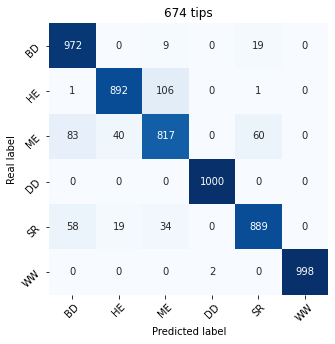

              precision    recall  f1-score   support

           0     0.8725    0.9720    0.9196      1000
           1     0.9380    0.8920    0.9144      1000
           2     0.8458    0.8170    0.8311      1000
           3     0.9980    1.0000    0.9990      1000
           4     0.9174    0.8890    0.9030      1000
           5     1.0000    0.9980    0.9990      1000

    accuracy                         0.9280      6000
   macro avg     0.9286    0.9280    0.9277      6000
weighted avg     0.9286    0.9280    0.9277      6000



In [22]:
label_names = ["BD", "HE", "ME", "DD", "SR", "WW"]
for i in results:
    plot_conf_mat((results[i]["y_pred"]), (results[i]["y_test"]), label_names, i)

### Calibrated model 

In [15]:
get_classification_results(results_calibrated_model)

,674
accuracy,0.923667
F1-Score,0.923356
Recall,0.923667
Precision,0.924233
Number of params,53110
Train time,963.543995


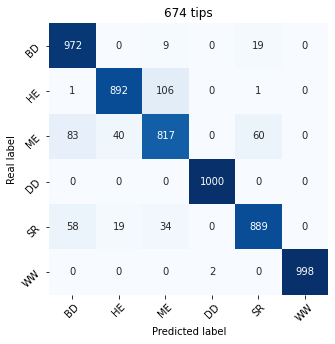

              precision    recall  f1-score   support

           0     0.8725    0.9720    0.9196      1000
           1     0.9380    0.8920    0.9144      1000
           2     0.8458    0.8170    0.8311      1000
           3     0.9980    1.0000    0.9990      1000
           4     0.9174    0.8890    0.9030      1000
           5     1.0000    0.9980    0.9990      1000

    accuracy                         0.9280      6000
   macro avg     0.9286    0.9280    0.9277      6000
weighted avg     0.9286    0.9280    0.9277      6000



In [23]:
label_names = ["BD", "HE", "ME", "DD", "SR", "WW"]
for i in results_calibrated_model:
    plot_conf_mat((results[i]["y_pred"]), (results[i]["y_test"]), label_names, i)

# Regression

In [17]:
pd.options.display.float_format = "{:,.4f}".format

In [18]:
with open(pickle_path + "dataset_" + "674" + "_1000_realrho_test.pkl", 'rb') as f:
    data = pickle.load(f)
res_path = "/workspace/deep_birth_death/deep_learning/models/reg/"

In [40]:
mae_dict = dict()
inf_times = dict()

    
for label in np.unique(data['div_info_test']):
    print(label)
    div_scenario = label.split('/')[1].split('_')[0]
    mae_dict[div_scenario] = dict()
    print(div_scenario)
    
    inf_times[div_scenario] = dict()
    
    norm_types = ['norm', 'no_norm']
    for norm in norm_types:
        mae_dict[div_scenario][norm] = dict()
        inf_times[div_scenario][norm] = dict()
        
        # Load regression model 
        model_path = res_path + div_scenario + '/' + "674" + "_regression_"
        if norm != 'no_norm':
            model_path += norm + '_'
        
        nn_model = load_model(model_path + 'model.keras')
    
    
    
    
        pred = nn_model.predict(np.expand_dims(data['X_test'][data['div_info_test'] == label], axis=2))
         
        
        
        if norm == 'norm':
            norm_text = '_norm'
        else:
            norm_text = ''
        y_reg_test = data['y_reg' + norm_text + '_test'][data['div_info_test'] == label]
        y_reg_test = [np.array(elem) for elem in y_reg_test]
        
        real = y_reg_test
        error = abs(pred-real)
        
        resc_factor_test = data['resc_factor_test'][data['div_info_test'] == label]
        
        if norm == 'norm':
            
            
            if div_scenario == "BD" or div_scenario == "HE" or div_scenario == "SAT":
                
                pred[:, 0] = pred[:, 0] / resc_factor_test

            elif div_scenario == "ME":
                
                pred[:, 0] = pred[:, 0] / resc_factor_test
                pred[:, 2] = pred[:, 2] / resc_factor_test

            else:
    
                pred[:, 0] = pred[:, 0] / resc_factor_test
                pred[:, 1] = pred[:, 1] / resc_factor_test
                pred[:, 4] = pred[:, 4] / resc_factor_test
                
            y_reg_test = data['y_reg_test'][data['div_info_test'] == label]
            y_reg_test = [np.array(elem) for elem in y_reg_test]
            
            real = y_reg_test
            error = abs(pred-real)
            r_error = abs((pred - real)/ real)
            raw_error = pred-real
            
            
            mae_dict[div_scenario][norm]['MAE'] = np.mean(error, axis=0)    
            mae_dict[div_scenario][norm]['MRE'] = np.mean(r_error, axis=0) 
            mae_dict[div_scenario][norm]['raw_error'] = raw_error
            mae_dict[div_scenario][norm]['abs_error'] = error
            
            
            
        else: 
        
            mae_dict[div_scenario][norm]['mae'] = np.mean(error, axis=0)
            
            if div_scenario == "BD" or div_scenario == "HE" or div_scenario == "SAT":
                
                pred[:, 0] = pred[:, 0] * resc_factor_test

            elif div_scenario == "ME":
                pred[:, 0] = pred[:, 0] * resc_factor_test
                pred[:, 2] = pred[:, 2] * resc_factor_test

            else:
                
                pred[:, 0] = pred[:, 0] * resc_factor_test
                pred[:, 1] = pred[:, 1] * resc_factor_test
                pred[:, 4] = pred[:, 4] * resc_factor_test
                
            
            y_reg_test = data['y_reg_norm_test'][data['div_info_test'] == label]
            y_reg_test = [np.array(elem) for elem in y_reg_test]
            
            
            
            real = y_reg_test
            error = abs(pred-real)                
            r_error = abs((pred - real)/ real)
            
            
            mae_dict[div_scenario][norm]['MAE'] = np.mean(error, axis=0)    
            mae_dict[div_scenario][norm]['MRE'] = np.mean(r_error, axis=0) 

674_1000_realrho_test/BD_sim_no_fossil1000_rescale.csv
BD
674_1000_realrho_test/HE_sim_no_fossil1000_rescale.csv
HE
674_1000_realrho_test/ME_rho_PGP_sim_no_fossil1000_rescale.csv
ME
674_1000_realrho_test/SAT_sim_no_fossil1000_rescale.csv
SAT
674_1000_realrho_test/SR_sim_no_fossil1000_rescale.csv
SR
674_1000_realrho_test/WW_sim_no_fossil1000_rescale.csv
WW


In [38]:
reg_values = {
    'BD': ['r', 'a'],
    'HE': ['r', 'a'],
    'ME': ['r', 'a', 'time', 'frac'],
    'SR': ['r0', 'r1', 'a0', 'a1', 'time'],
    'WW': ['r0', 'r1', 'a0', 'a1', 'time'],
    'SAT': ['lambda0'],
}

scenarios = ["BD", "HE", "ME", "SAT", "SR", "WW"]

In [39]:

for div_scenario in scenarios:   
    param_names = reg_values[div_scenario]
    mae_vals =  mae_dict[div_scenario]["norm"]['MAE']
    mre_vals =  mae_dict[div_scenario]["norm"]['MRE']
    
    df = pd.DataFrame({
            "param": param_names,
            "MAE": mae_vals,
            "MRE": mre_vals
        })
    
    print("MAE and MRE for :" + div_scenario + " diversification scenario")
    print(df.to_string(index=False))

MAE and MRE for :BD diversification scenario
param    MAE    MRE
    r 0.1321 0.0645
    a 0.1119 0.7683
MAE and MRE for :HE diversification scenario
param    MAE    MRE
    r 0.2071 0.1038
    a 0.0215 0.0251
MAE and MRE for :ME diversification scenario
param    MAE    MRE
    r 0.0342 0.1125
    a 0.0794 0.1447
 time 5.0496 0.7210
 frac 0.0497 0.2966
MAE and MRE for :SAT diversification scenario
  param    MAE    MRE
lambda0 0.0610 0.0313
MAE and MRE for :SR diversification scenario
param    MAE    MRE
   r0 0.0742 0.1259
   r1 0.0224 0.5997
   a0 0.1097 0.6833
   a1 0.0965 0.1335
 time 3.7160 0.5907
MAE and MRE for :WW diversification scenario
param    MAE    MRE
   r0 0.0349 0.4834
   r1 0.1033 0.1143
   a0 0.1690 0.1084
   a1 0.0856 0.2244
 time 2.8708 0.2708


--------- BD ---------


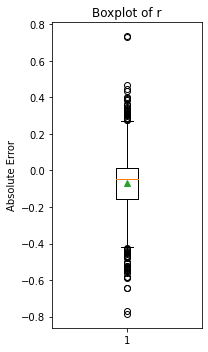

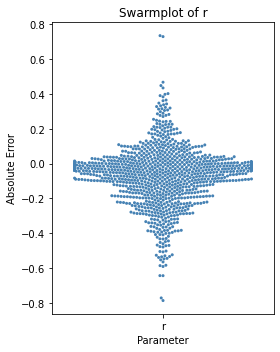

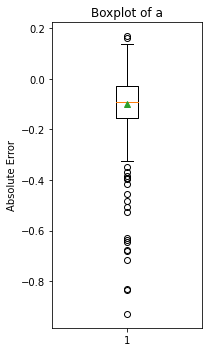

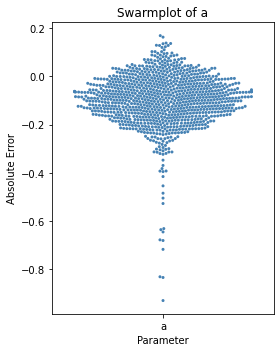

--------- HE ---------


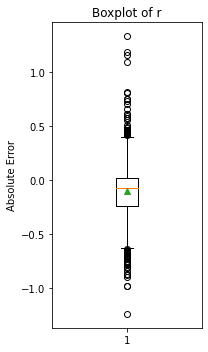

/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


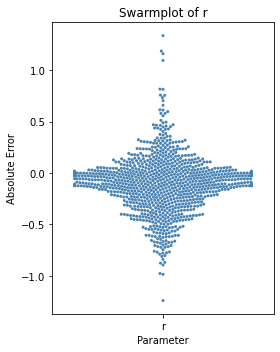

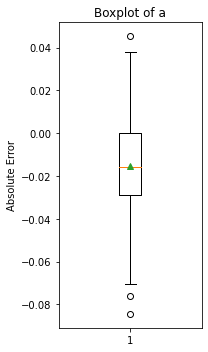

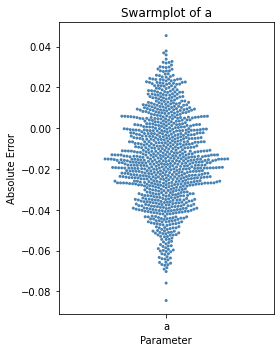

--------- ME ---------


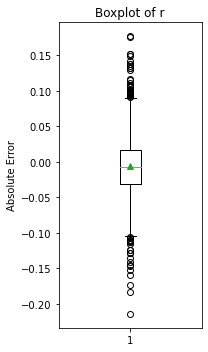

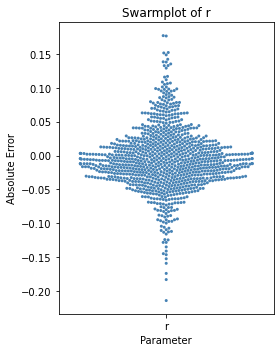

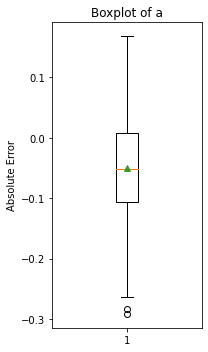

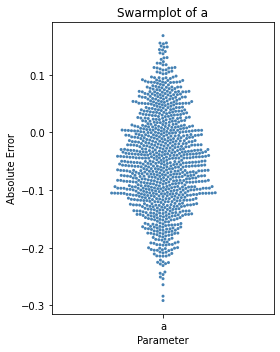

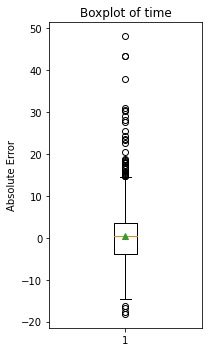

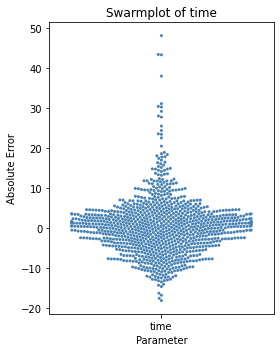

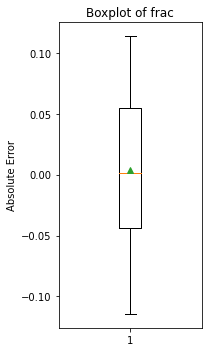

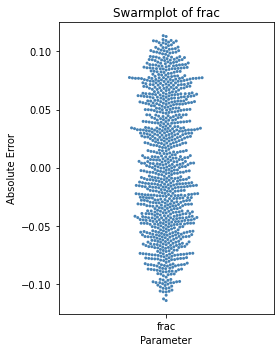

--------- SAT ---------


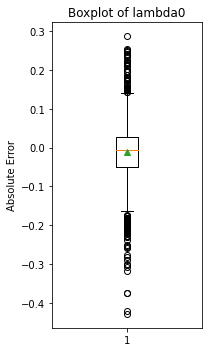

/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


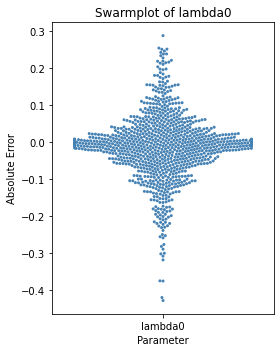

--------- SR ---------


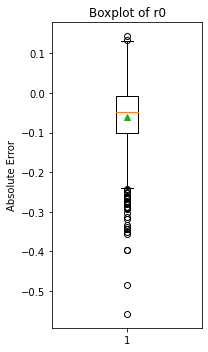

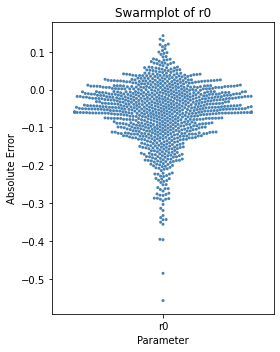

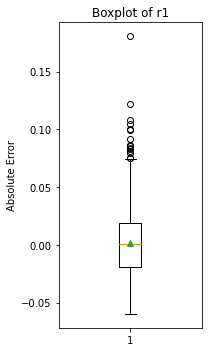

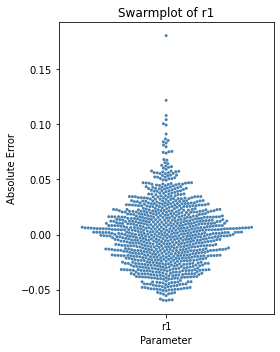

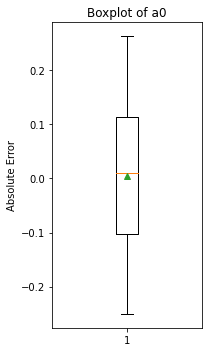

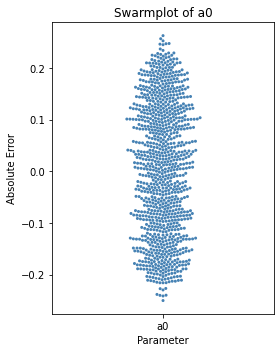

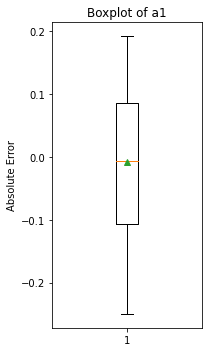

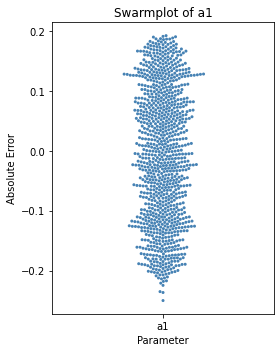

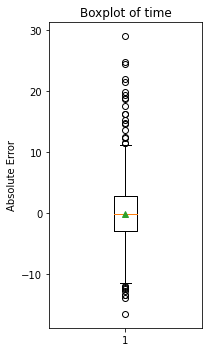

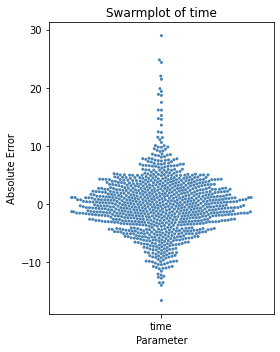

--------- WW ---------


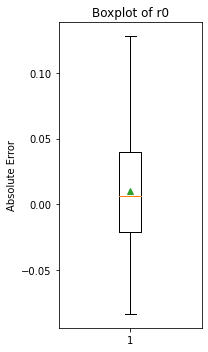

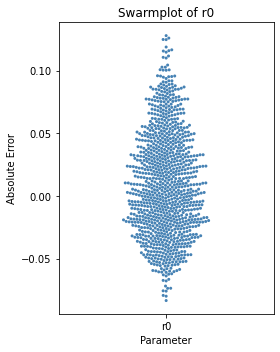

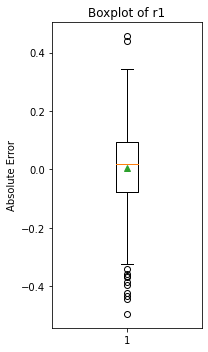

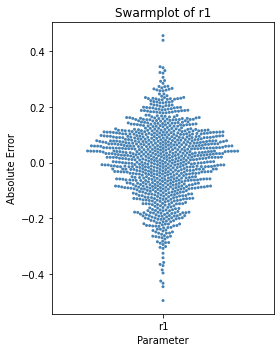

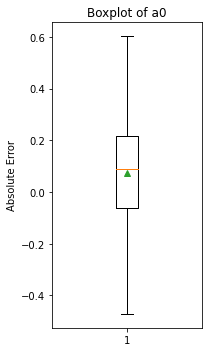

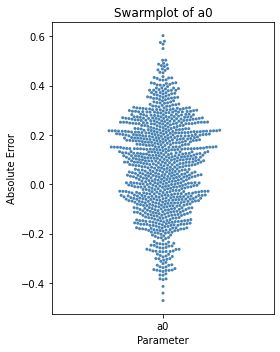

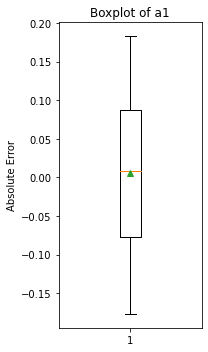

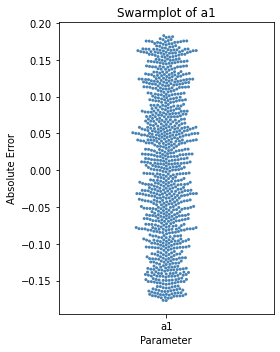

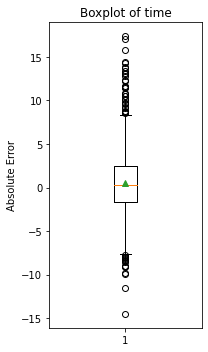

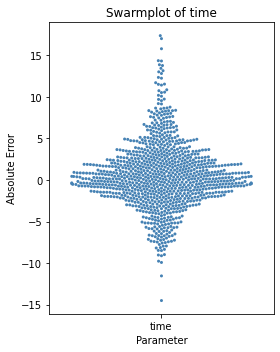

In [51]:
for scenario in scenarios:
    print(f"--------- {scenario} ---------")
    
    param_names = reg_values[scenario]
    errors = mae_dict[scenario]["norm"]['raw_error']

    for i, param in enumerate(param_names):
        values = errors[:, i]
        
        # Boxplot
        fig, ax = plt.subplots(figsize=(3, 5))
        ax.boxplot(values, showmeans=True)
        ax.set_title(f"Boxplot of {param}")
        ax.set_ylabel("Absolute Error")
        plt.tight_layout()
        plt.show()
        
        # Swarmplot
        df_plot = pd.DataFrame({
            'Error': values,
            'Parameter': param
        })

        fig, ax = plt.subplots(figsize=(4, 5))
        sns.swarmplot(data=df_plot, x="Parameter", y="Error", size=3, color='steelblue', ax=ax)
        ax.set_title(f"Swarmplot of {param}")
        ax.set_ylabel("Absolute Error")
        plt.tight_layout()
        plt.show()

In [55]:
print(data.keys())

dict_keys(['X_train', 'X_test', 'y_class_train', 'y_class_test', 'y_reg_train', 'y_reg_test', 'y_reg_norm_train', 'y_reg_norm_test', 'resc_factor_train', 'resc_factor_test', 'div_info_train', 'div_info_test'])


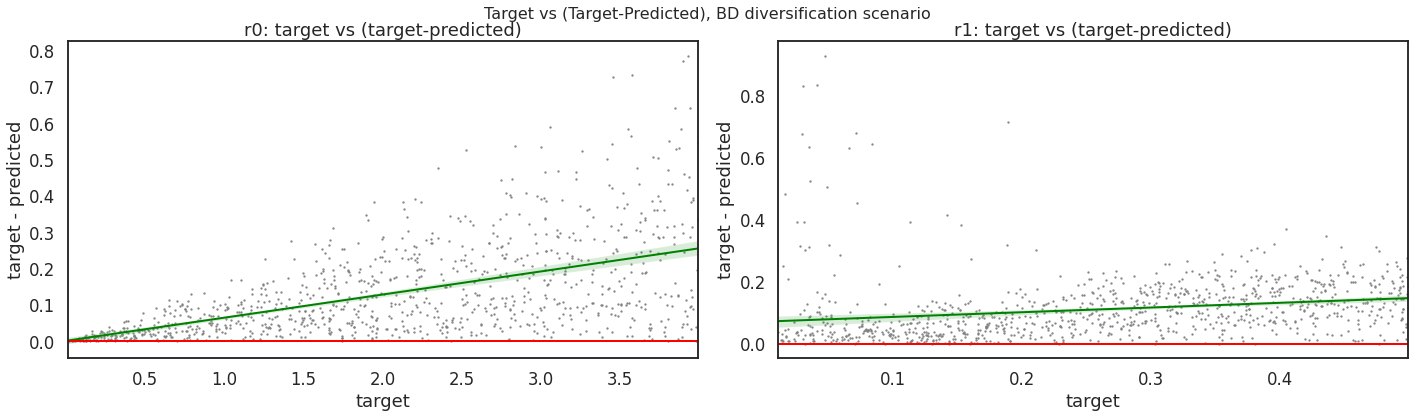

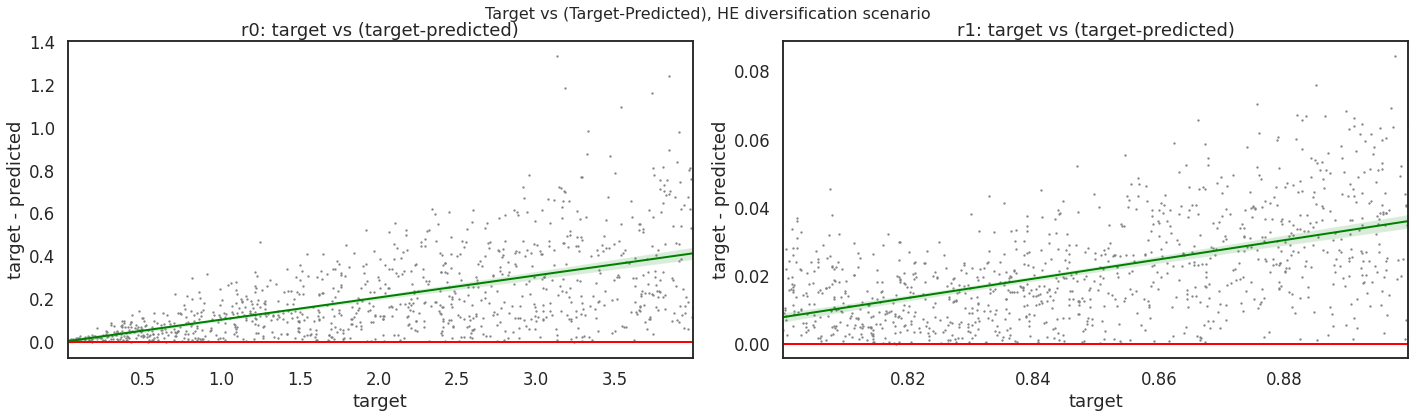

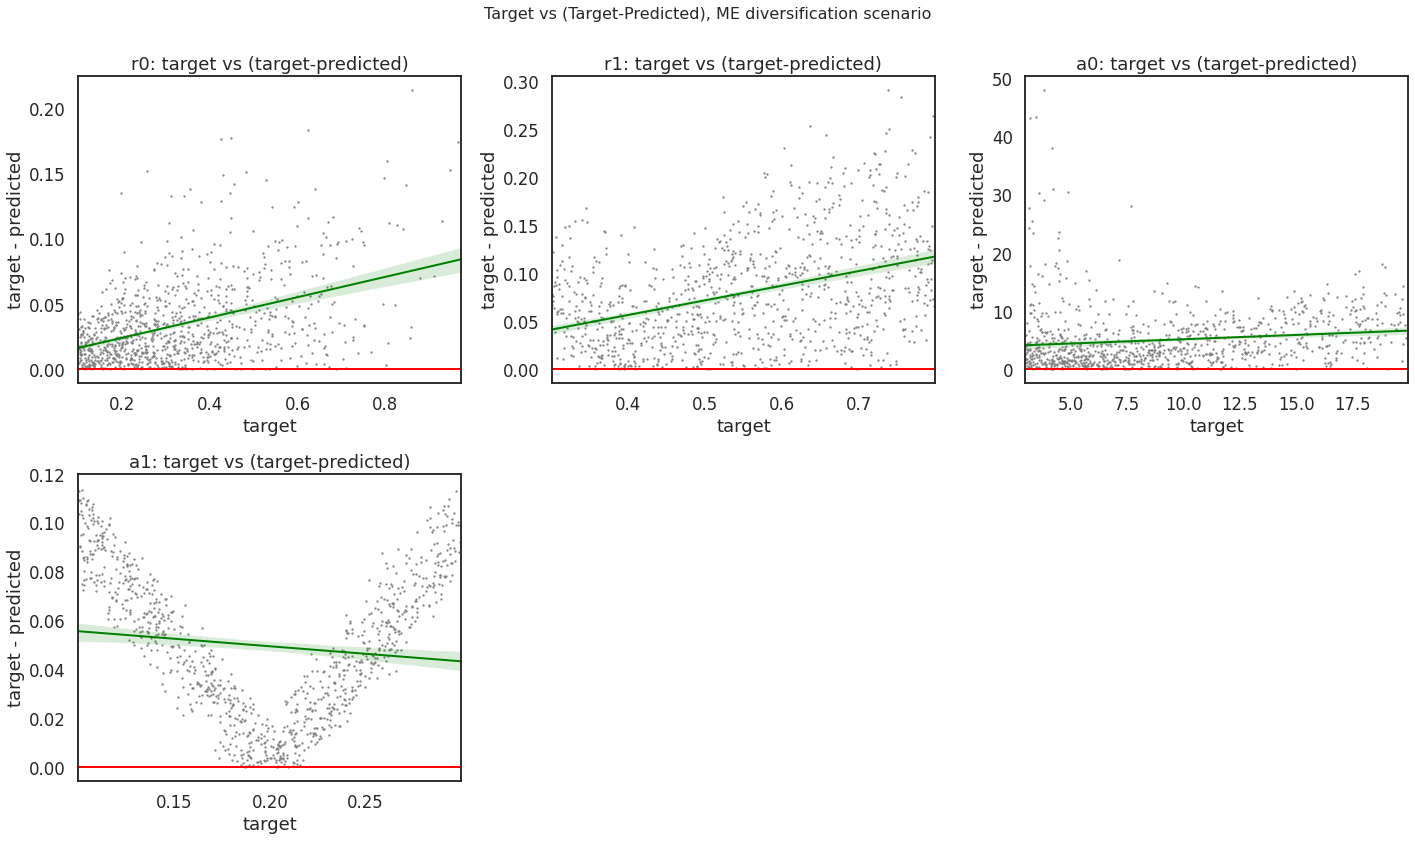

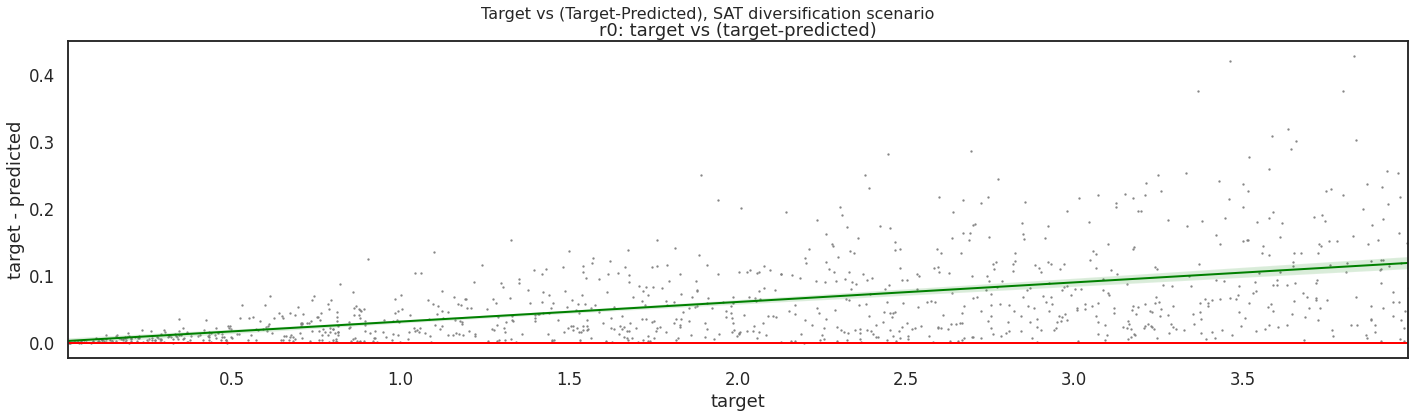

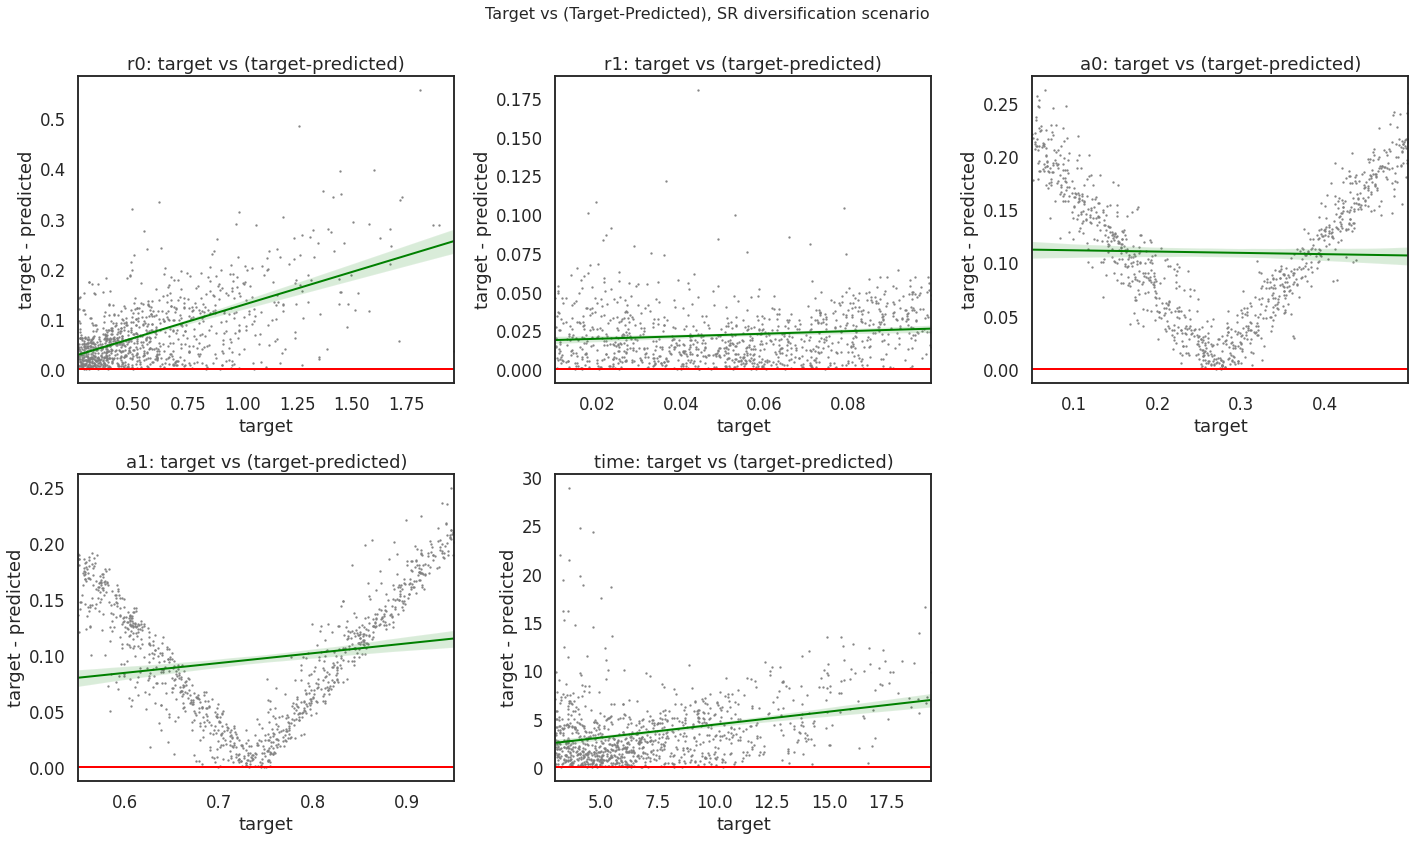

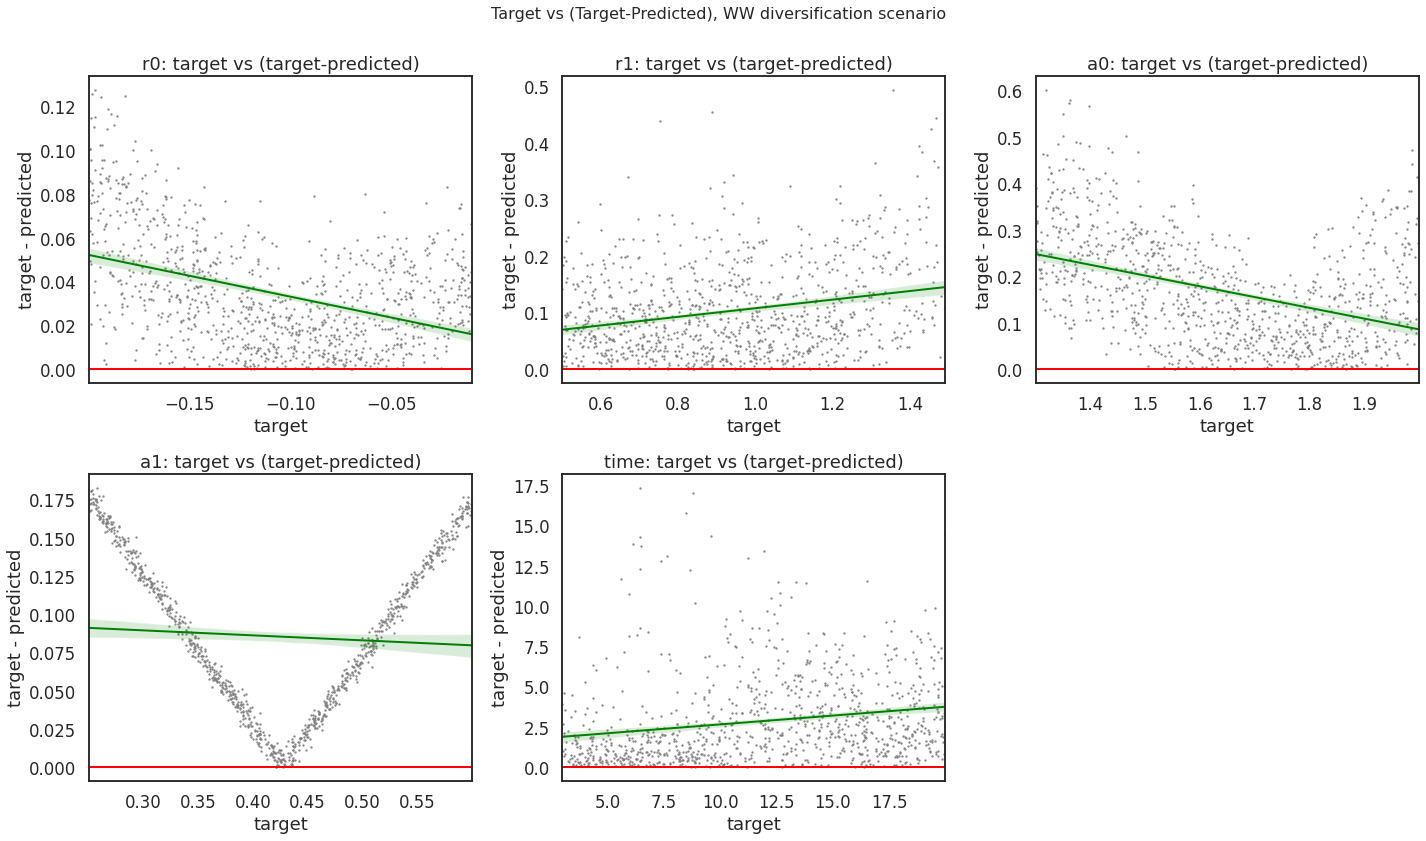

In [62]:
for label in np.unique(data['div_info_test']):
    div_scenario = label.split('/')[1].split('_')[0]

    
    n_params = len(reg_values[div_scenario])
    n_cols = min(n_params, 3)
    n_rows = math.ceil(n_params / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    
    sns.set_style('white')
    sns.set_context('talk')
    
    if isinstance(axes, plt.Axes):
        axes_list = [axes]
    else:
        axes_list = axes.flatten().tolist()
        
    abs_errors = mae_dict[div_scenario]["norm"]['abs_error']
    
    y_test = data['y_reg_test'][data['div_info_test'] == label]
    y_test = np.array(y_test.tolist())

    for i, ax in enumerate(axes_list):
        if i < n_params:
            param_name = param_names[i]
            
            if errors.ndim == 2:
                err_i = abs_errors[:, i]
            else:
                err_i = abs_errors
            
            sns.regplot(x=y_test[:, i], y=err_i, ci=95, n_boot=500, 
                        scatter_kws={'s': 2, 'color': 'grey'}, 
                        line_kws={'color': 'green', 'linewidth': 2}, ax=ax)

            innerlimit = min(y_test[:, i])
            outerlimit = max(y_test[:, i])
            ax.plot([innerlimit, outerlimit], [0, 0], linewidth=2, color='red')

            ax.set_title(f'{param_name}: target vs (target-predicted)')
            ax.set_xlabel('target')
            ax.set_ylabel('target - predicted')
        else:
            ax.axis('off')

    fig.suptitle(f'Target vs (Target-Predicted), {div_scenario} diversification scenario', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()